In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
# Load in our pre-created train and validation splits -- not touching the test split yet!

X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
y_train = pd.read_csv('y_train.csv', header=None)
y_val = pd.read_csv('y_val.csv', header=None)

In [3]:
# The CSV process seems to introduce an unwanted column we need to drop.

X_train.drop(['Unnamed: 0'], axis=1, inplace=True)
X_val.drop(['Unnamed: 0'], axis=1, inplace=True)

y_train.drop(y_train.columns[0], axis=1, inplace=True)
y_val.drop(y_val.columns[0], axis=1, inplace=True)

print(X_train.shape)
print(y_train.shape)
y_train.head()

(38385, 15)
(38385, 1)


,1
0,3
1,3
2,3
3,5
4,3


In [4]:
# Testing how we need to reshape y_train to get it to work in our model in the next cell.

np.array(y_train).reshape(-1,)

array([3, 3, 3, ..., 0, 0, 0])

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=500, max_depth=30)

rfc.fit(X_train, np.array(y_train).reshape(-1,))

y_pred = rfc.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.560126582278481


In [6]:
from sklearn.metrics import confusion_matrix

# Modified from Gabe's function to take in X_val and y_val and not assume variable names

def make_confusion_matrix(model_, X_v, y_v):
   y_predict = model_.predict(X_v)
   confusion_matrix(y_v, y_predict)
   plt.figure(figsize = (15,8))
   sns.heatmap(confusion_matrix(y_v, y_predict),annot=True, fmt='g', cmap = 'Blues')
   return y_predict

array([0, 0, 0, ..., 1, 1, 1])

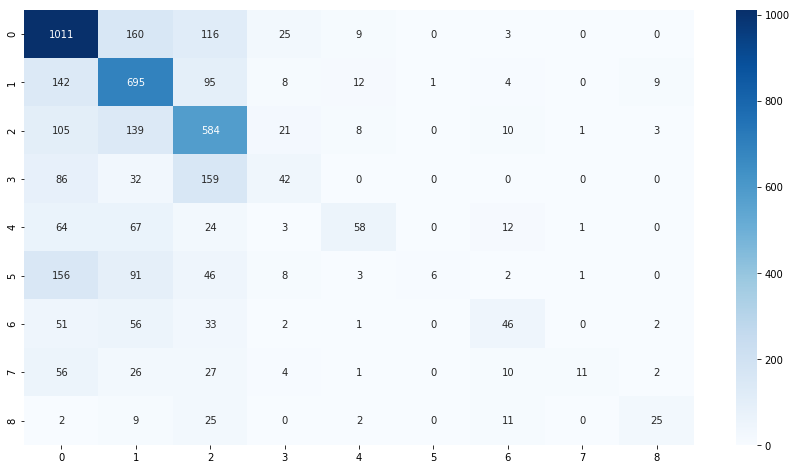

In [7]:
make_confusion_matrix(rfc, X_val, y_val)

In [8]:
import xgboost as xgb

# I'm not using the early stopping rounds feature because this model already takes a pretty long time to run.
# The below represents the outcome of my parameter tuning. The best result I got was .6044 but it doesn't always
# replicate due to random states.

gbm = xgb.XGBClassifier( 
                        n_estimators=800,
                        max_depth=8,
                        objective='multi:softmax',
                        num_class=9,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

fit_model = gbm.fit( 
                    X_train, np.array(y_train).reshape(-1,), 
                    eval_metric='error',
                    verbose=False
                   )

accuracy_score(y_val, gbm.predict(X_val))

0.6023960216998192

array([0, 0, 0, ..., 1, 1, 1])

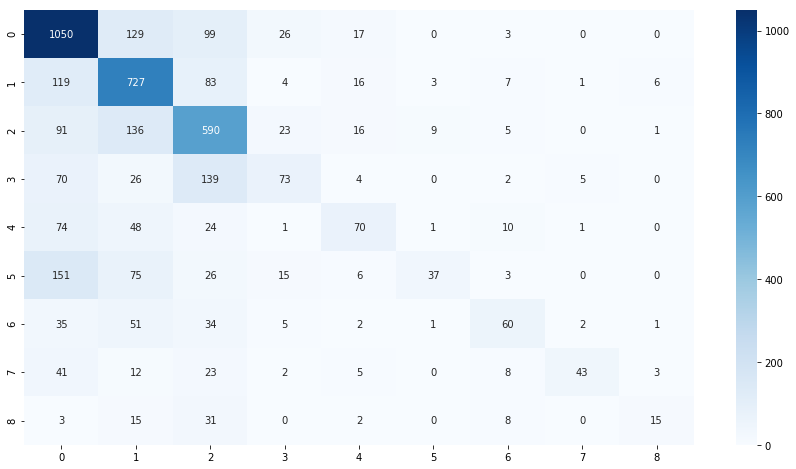

In [9]:
make_confusion_matrix(gbm, X_val, y_val)

In [10]:
# 60.4% correct classification is pretty solid for 9 unbalanced genres, although the model is definitely uneven
# in terms of what it gets right and wrong. Let's fit a new model on the oversampled training data to see if it
# improves the overall accuracy, but especially among the six smaller genres.

X_train_oversmp = pd.read_csv('X_train_oversmp.csv')
y_train_oversmp = pd.read_csv('y_train_oversmp.csv')

X_train_oversmp.drop(['Unnamed: 0'], axis=1, inplace=True)

y_train_oversmp.drop(y_train_oversmp.columns[0], axis=1, inplace=True)

print(X_train_oversmp.shape)
print(y_train_oversmp.shape)
y_train_oversmp.head()

(102546, 15)
(102546, 1)


,0
0,3
1,3
2,3
3,5
4,3


In [11]:
gbm_oversmp = xgb.XGBClassifier( 
                        n_estimators=800,
                        max_depth=8,
                        objective='multi:softmax',
                        num_class=9,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

fit_model = gbm_oversmp.fit( 
                    X_train_oversmp, np.array(y_train_oversmp).reshape(-1,), 
                    eval_metric='error',
                    verbose=False
                   )

accuracy_score(y_val, gbm_oversmp.predict(X_val))

0.5987793851717902

array([0, 0, 0, ..., 1, 1, 1])

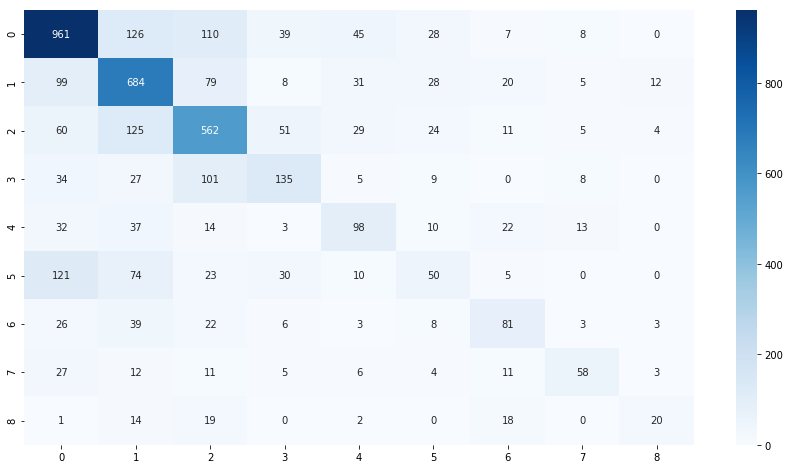

In [12]:
make_confusion_matrix(gbm_oversmp, X_val, y_val)

In [13]:
# Out of curiosity I want to see how a model does with just the three big genres since it seems to be much more
# accurate for them:

X_train_top3 = pd.read_csv('X_train_top3.csv')
X_val_top3 = pd.read_csv('X_val_top3.csv')
y_train_top3 = pd.read_csv('y_train_top3.csv', header=None)
y_val_top3 = pd.read_csv('y_val_top3.csv', header=None)

X_train_top3.drop(['Unnamed: 0'], axis=1, inplace=True)
X_val_top3.drop(['Unnamed: 0'], axis=1, inplace=True)

y_train_top3.drop(y_train_top3.columns[0], axis=1, inplace=True)
y_val_top3.drop(y_val_top3.columns[0], axis=1, inplace=True)

print(X_train_top3.shape)
print(y_train_top3.shape)
y_train_top3.head()

(27613, 15)
(27613, 1)


,1
0,0
1,0
2,1
3,1
4,1


In [14]:
gbm_top3 = xgb.XGBClassifier( 
                        n_estimators=800,
                        max_depth=8,
                        objective='multi:softmax',
                        num_class=9,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

fit_model_top3 = gbm_top3.fit( 
                    X_train_top3, np.array(y_train_top3).reshape(-1,), 
                    eval_metric='error',
                    verbose=False
                   )

accuracy_score(y_val_top3, gbm_top3.predict(X_val_top3))

0.7696931350838342

array([0, 0, 0, ..., 1, 1, 1])

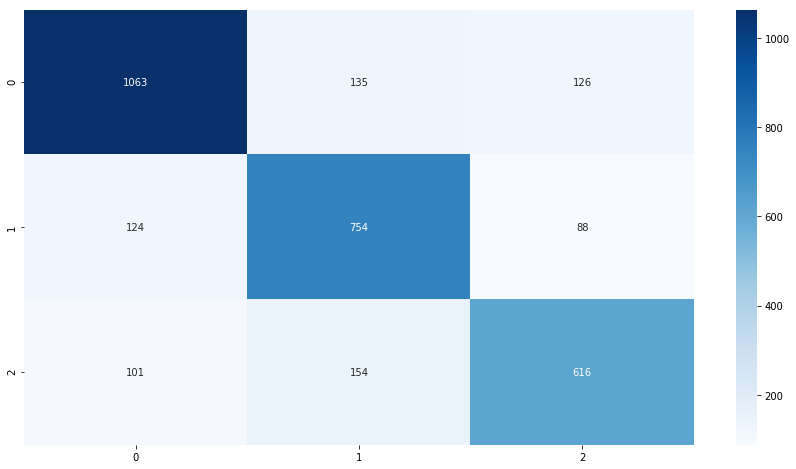

In [15]:
make_confusion_matrix(gbm_top3, X_val_top3, y_val_top3)

In [16]:
# We're going to pickle all three models for use in my Flask app:

import pickle

pickle.dump(gbm, open('gradient_boost_genre.pkl', 'wb'))
pickle.dump(gbm_oversmp, open('gradient_boost_oversmp_genre.pkl', 'wb'))
pickle.dump(gbm_top3, open('gradient_boost_top3_genre.pkl', 'wb'))

#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))

In [17]:
# Finally, let's run our models on the test data! First, load in and prep the test data.

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv', header=None)

X_test.drop(['Unnamed: 0'], axis=1, inplace=True)

y_test.drop(y_test.columns[0], axis=1, inplace=True)

print(X_test.shape)
print(y_test.shape)
y_test.head()

(4738, 15)
(4738, 1)


,1
0,0
1,0
2,0
3,0
4,0


0.5827353313634445


array([0, 0, 4, ..., 0, 0, 2])

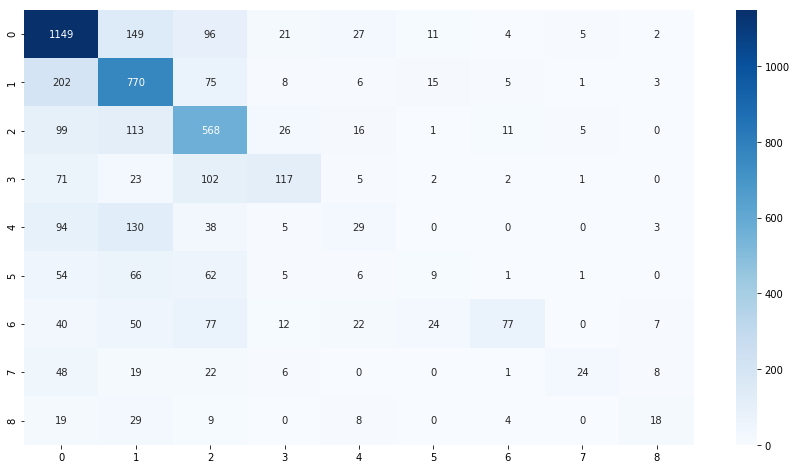

In [18]:
# This is our original best model with unbalanced genres in X_train:

print(accuracy_score(y_test, gbm.predict(X_test)))
make_confusion_matrix(gbm, X_test, y_test)

0.5728155339805825


array([4, 0, 4, ..., 0, 0, 2])

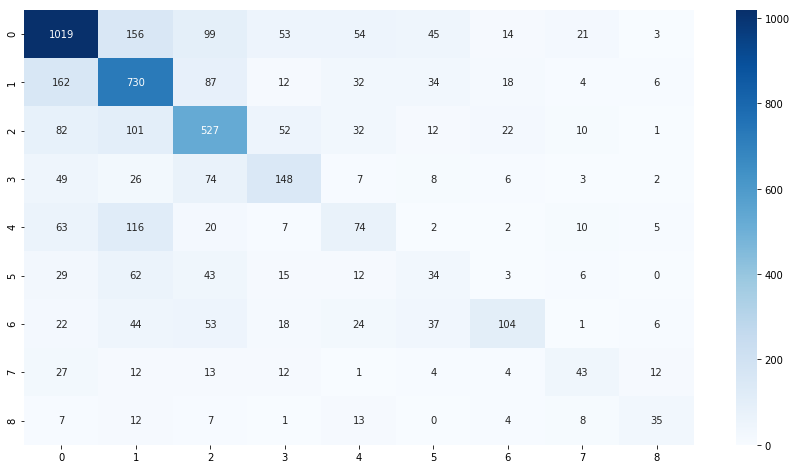

In [19]:
# This is our model that included oversampling via SMOTE to balance genres in X_train:

print(accuracy_score(y_test, gbm_oversmp.predict(X_test)))
make_confusion_matrix(gbm_oversmp, X_test, y_test)

In [20]:
# Let's do the same for our three-genre model:

X_test_top3 = pd.read_csv('X_test_top3.csv')
y_test_top3 = pd.read_csv('y_test_top3.csv', header=None)

X_test_top3.drop(['Unnamed: 0'], axis=1, inplace=True)

y_test_top3.drop(y_test_top3.columns[0], axis=1, inplace=True)

print(X_test_top3.shape)
print(y_test_top3.shape)
y_test_top3.head()

(3388, 15)
(3388, 1)


,1
0,0
1,0
2,0
3,0
4,0


0.7570838252656434


array([0, 0, 0, ..., 0, 0, 0])

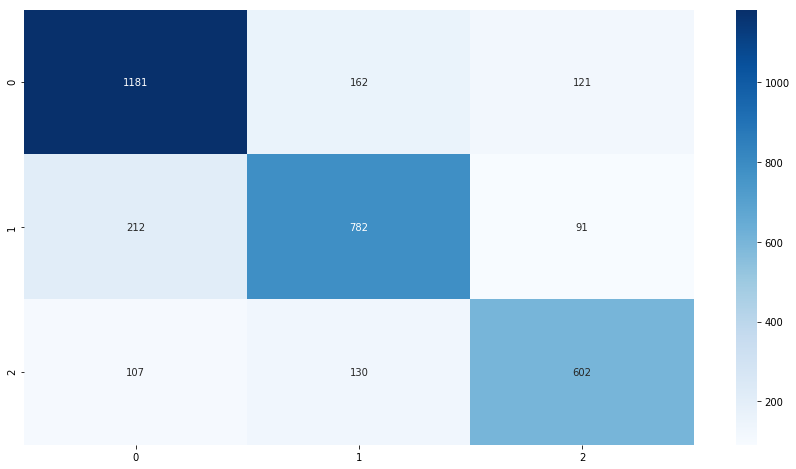

In [21]:
print(accuracy_score(y_test_top3, gbm_top3.predict(X_test_top3)))
make_confusion_matrix(gbm_top3, X_test_top3, y_test_top3)